# 1 Import Packages

In [1]:
import xarray as xr
import sys, os
from pathlib import Path
import glob
from cdo import Cdo
import matplotlib.pyplot as plt
import numpy as np


In [2]:
cdo = Cdo()

-->> Could not load netCDF4! <<--


# 2 Metadata

In [3]:
sys.path.append(os.path.abspath(Path().resolve().parents[1]))
import config

# 3 Load Data

In [134]:
data_path = os.path.join(config.data_raw_path, "hist", "lkm0001")
data_filename = "_".join(["lkm0001", "hist", "mpiom","data","3d", "mm", "*_*"])+".nc"

In [ ]:
data_filename = 

In [ ]:
dataset = xr.open_mfdataset(os.path.join(data_path, data_filename))

In [140]:
output_string = cdo.yearmonmean(input=dataset)

-->> Could not load netCDF4! <<--


In [142]:
xr.load_dataset(output_string)

<xarray.Dataset>
Dimensions:    (time: 1, bnds: 2, j: 220, i: 256, vertices: 4, lev: 40)
Coordinates:
  * time       (time) datetime64[ns] 1950-07-01T06:00:00
    lon        (j, i) float32 312.7 312.3 311.9 311.5 ... 131.3 132.5 133.8
    lat        (j, i) float32 76.36 76.3 76.24 76.17 ... -77.25 -77.39 -77.54
  * i          (i) int32 0 1 2 3 4 5 6 7 8 ... 248 249 250 251 252 253 254 255
  * j          (j) int32 0 1 2 3 4 5 6 7 8 ... 212 213 214 215 216 217 218 219
  * lev        (lev) float64 6.0 17.0 27.0 37.0 ... 4.67e+03 5.17e+03 5.72e+03
Dimensions without coordinates: bnds, vertices
Data variables:
    time_bnds  (time, bnds) datetime64[ns] 1950-01-01 1951-01-01
    lon_bnds   (j, i, vertices) float32 312.8 313.1 312.6 ... 133.5 136.1 138.6
    lat_bnds   (j, i, vertices) float32 76.44 76.33 76.27 ... -77.47 -77.75
    lev_bnds   (lev, bnds) float64 0.0 11.5 11.5 ... 5.445e+03 5.72e+03
    rhopoto    (time, lev, j, i) float32 nan nan nan nan nan ... nan nan nan nan
    so         (time, lev, j, i) float32 nan nan nan nan nan ... nan nan nan nan
    thetao     (time, lev, j, i) float32 nan nan nan nan nan ... nan nan nan nan
Attributes: (12/29)
    CDI:                    Climate Data Interface version 1.9.10 (https://mp...
    Conventions:            CF-1.4
    source:                 MPI-ESM 1.1.00p2
    institution:            Max-Planck-Institut fuer Meteorologie
    history:                Mon Jan 30 17:22:40 2023: cdo -O -s -yearmonmean ...
    institute_id:           MPI-M
    ...                     ...
    title:                  MPI-ESM model output prepared for CMIP5 historical
    parent_experiment:      pre-industrial control
    modeling_realm:         ocean
    realization:            1
    cmor_version:           2.9.1
    CDO:                    Climate Data Operators version 1.9.10 (https://mp...

In [5]:
dataset = xr.load_dataset(os.path.join(data_path, data_filename))

# 4 Processing

## 4.1 Unit Check

In [10]:
dataset["so"].attrs

{'standard_name': 'sea_water_salinity',
 'long_name': 'Sea Water Salinity',
 'units': 'psu',
 'cell_methods': 'time: mean',
 'cell_measures': 'area: areacello volume: volcello',
 'history': '2018-11-02T00:09:05Z altered by CMOR: replaced missing value flag (-9e+33) with standard missing value (1e+20).',
 'associated_files': 'baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation gridspecFile: gridspec_ocean_fx_MPI-ESM_historical_r0i0p0.nc areacello: areacello_fx_MPI-ESM_historical_r0i0p0.nc volcello: volcello_fx_MPI-ESM_historical_r0i0p0.nc'}

In [11]:
dataset["so"].attrs["units"]

'psu'

The unit for the potential temperature is wrong ! It should be celsius but it is Kelvin. Does that influence the calculation of density in cdo ?

In [12]:
dataset["thetao"].attrs

{'standard_name': 'sea_water_potential_temperature',
 'long_name': 'Sea Water Potential Temperature',
 'units': 'K',
 'cell_methods': 'time: mean',
 'cell_measures': 'area: areacello volume: volcello',
 'history': '2018-11-01T23:36:17Z altered by CMOR: replaced missing value flag (-9e+33) with standard missing value (1e+20).',
 'associated_files': 'baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation gridspecFile: gridspec_ocean_fx_MPI-ESM_historical_r0i0p0.nc areacello: areacello_fx_MPI-ESM_historical_r0i0p0.nc volcello: volcello_fx_MPI-ESM_historical_r0i0p0.nc'}

In [13]:
dataset["thetao"].attrs["units"]

'K'

# Calculate in Situe Temperature

In [72]:
cdo.adisit(input=dataset, output="temp.nc" )

temp = xr.load_dataset("temp.nc")

-->> Could not load netCDF4! <<--


## check that salinity is the same as before

In [66]:
salinity_differences = dataset["so"] - temp["s"]

In [75]:
np.testing.assert_array_equal(xr.zeros_like(salinity_differences),salinity_differences.fillna(0))

In [76]:
salinity_differences.max().values

array(0.)

In [77]:
salinity_differences.min().values

array(0.)

In [20]:
temp["s"].attrs

{'standard_name': 'sea_water_salinity',
 'long_name': 'Sea water salinity',
 'units': 'psu',
 'code': 5}

In [18]:
temp["to"].attrs

{'standard_name': 'sea_water_temperature',
 'long_name': 'Sea water temperature',
 'units': 'K',
 'code': 20}

In [31]:
dataset["thetao"].min()

<xarray.DataArray 'thetao' ()>
array(-1.89999998)

# Calculate In Situ Density

In [85]:
cdo.rhopot(input=temp, output="rho.nc" )
cdo.rhopot(0,input=temp, output="rhopot.nc")


-->> Could not load netCDF4! <<--
-->> Could not load netCDF4! <<--


'rhopot.nc'

In [86]:
rhopot = xr.load_dataset("rhopot.nc")

In [87]:
rho = xr.load_dataset("rho.nc")

In [104]:
min_distance = np.min(np.abs(rho.lat - 26.5) + np.abs(rho.lon - (-40)))

In [105]:
min_distance

<xarray.DataArray ()>
array(40.72505188)

In [106]:
i_test = 116
j_test = 101

In [113]:
rhopot.lev

<xarray.DataArray 'lev' (lev: 40)>
array([   6. ,   17. ,   27. ,   37. ,   47. ,   57. ,   68.5,   82.5,  100. ,
        122.5,  150. ,  182.5,  220. ,  262.5,  310. ,  362.5,  420. ,  485. ,
        560. ,  645. ,  740. ,  845. ,  960. , 1085. , 1220. , 1365. , 1525. ,
       1700. , 1885. , 2080. , 2290. , 2525. , 2785. , 3070. , 3395. , 3770. ,
       4195. , 4670. , 5170. , 5720. ])
Coordinates:
  * lev      (lev) float64 6.0 17.0 27.0 37.0 ... 4.67e+03 5.17e+03 5.72e+03
Attributes:
    standard_name:  depth
    long_name:      ocean depth coordinate
    units:          m
    positive:       down
    axis:           Z
    bounds:         lev_bnds

In [115]:
rhopot.sel(i=i_test, j=j_test)["rhopoto"].isel(time=0)

<xarray.DataArray 'rhopoto' (lev: 40)>
array([1025.3373, 1025.3359, 1025.3348, 1025.334 , 1025.3333, 1025.3326,
       1025.3445, 1025.481 , 1025.7649, 1025.9987, 1026.1469, 1026.2513,
       1026.35  , 1026.4663, 1026.553 , 1026.6259, 1026.6863, 1026.777 ,
       1026.8607, 1027.063 , 1027.1368, 1027.2133, 1027.2734, 1027.4042,
       1027.5609, 1027.6173, 1027.6559, 1027.6833, 1027.6906, 1027.6909,
       1027.6906, 1027.6948, 1027.705 , 1027.7177, 1027.7239, 1027.725 ,
       1027.7212, 1027.7156, 1027.7089,       nan], dtype=float32)
Coordinates:
    time     datetime64[ns] 1950-01-16T12:00:00
    lon      float32 325.3
    lat      float32 22.52
    i        int32 116
    j        int32 101
  * lev      (lev) float64 6.0 17.0 27.0 37.0 ... 4.67e+03 5.17e+03 5.72e+03
Attributes:
    standard_name:  sea_water_potential_density
    long_name:      Sea water potential density
    units:          kg m-3
    code:           18

In [116]:
rhopot.lev

<xarray.DataArray 'lev' (lev: 40)>
array([   6. ,   17. ,   27. ,   37. ,   47. ,   57. ,   68.5,   82.5,  100. ,
        122.5,  150. ,  182.5,  220. ,  262.5,  310. ,  362.5,  420. ,  485. ,
        560. ,  645. ,  740. ,  845. ,  960. , 1085. , 1220. , 1365. , 1525. ,
       1700. , 1885. , 2080. , 2290. , 2525. , 2785. , 3070. , 3395. , 3770. ,
       4195. , 4670. , 5170. , 5720. ])
Coordinates:
  * lev      (lev) float64 6.0 17.0 27.0 37.0 ... 4.67e+03 5.17e+03 5.72e+03
Attributes:
    standard_name:  depth
    long_name:      ocean depth coordinate
    units:          m
    positive:       down
    axis:           Z
    bounds:         lev_bnds

The newly calculated potential density is not the same as the original potential density. Maybe just numerics ? 

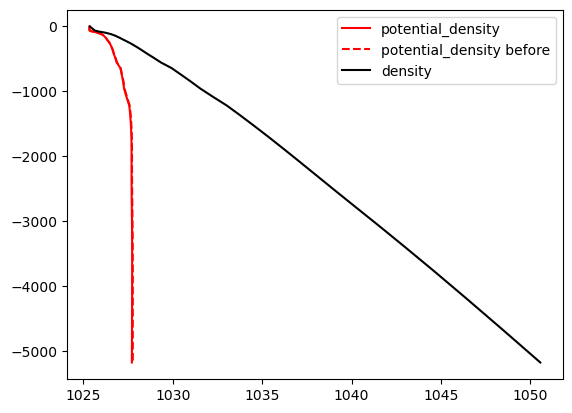

In [131]:
plt.plot(rhopot.sel(i=i_test, j=j_test)["rhopoto"].isel(time=0), -rhopot.lev, color="red", label="potential_density")
plt.plot(dataset.sel(i=i_test, j=j_test)["rhopoto"].isel(time=0), -rhopot.lev, color="red", linestyle="--", label="potential_density before")
plt.plot(rho.sel(i=i_test, j=j_test)["rhopoto"].isel(time=0), -rho.lev, color="black", label="density")

plt.legend()

In [129]:
(rhopot["rhopoto"] - dataset["rhopoto"]).max()

<xarray.DataArray 'rhopoto' ()>
array(0.22912598)

In [128]:
(rhopot["rhopoto"] - dataset["rhopoto"]).min()

<xarray.DataArray 'rhopoto' ()>
array(-0.13012695)